## Team Data_Deciphers
### Identifying major drivers for sales(EQ)

In [167]:
#Importing the necessary libraries
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.linear_model import ElasticNetCV, ElasticNet

import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

In [168]:
#Reading the csv file
data=pd.read_csv('Training-Data-Sets.csv', index_col=0)

In [169]:
#Let's have a look at the data
data.head(2)

,EQ,Social_Search_Impressions,Social_Search_Working_cost,Digital_Impressions,Digital_Working_cost,Print_Impressions.Ads40,Print_Working_Cost.Ads50,OOH_Impressions,OOH_Working_Cost,SOS_pct,...,Magazine_Impressions_pct,TV_GRP,Competitor1_RPI,Competitor2_RPI,Competitor3_RPI,Competitor4_RPI,EQ_Category,EQ_Subcategory,pct_PromoMarketDollars_Subcategory,RPI_Subcategory
Day,,,,,,,,,,,,,,,,,,,,,
1,718.458667,22256928,56812,7724107,238700,151438,1044,112229070,2133614,5,...,54.17,16.46,105.71,36.13,46.36,71.83,5420048,475559,0.3766,45.77
2,25.521137,4239408,105695,5844288,188902,264008,113582,284597324,1719318,38,...,65.79,15.64,111.79,43.31,47.58,67.90,12155631,371540,0.2515,35.02


In [170]:
print('Shape of the dataset:',data.shape)

Shape of the dataset: (12000, 38)


In [171]:
#Is there any nan value?
data.isna().values.any()

False

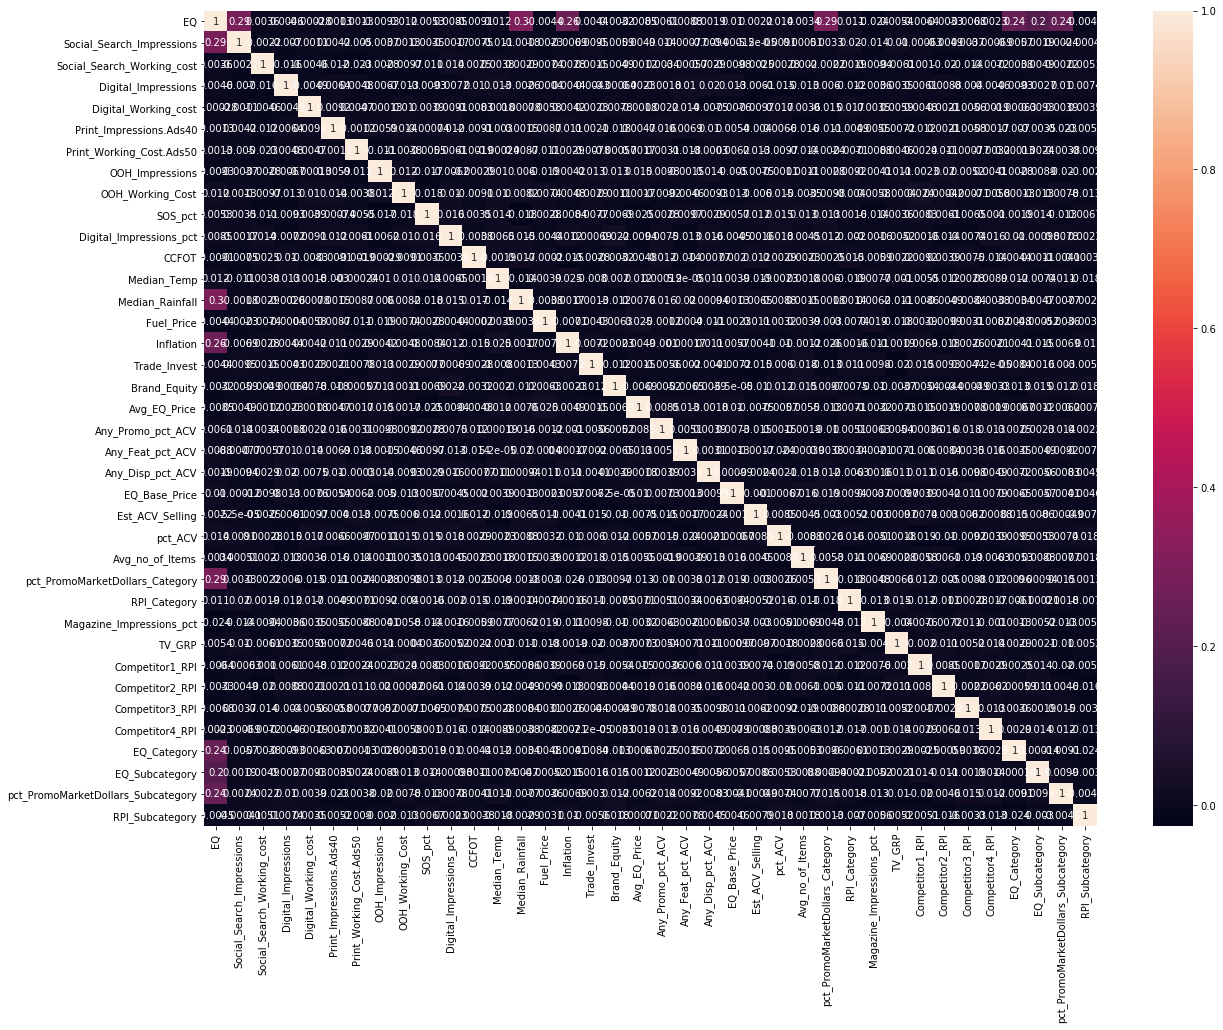

In [172]:
#Heatmap with the correlation coefficients
plt.figure(figsize = (20,15))
corr = data.corr()
sns.heatmap(corr, annot = True)


 mu = 638.01 and sigma = 1200.06



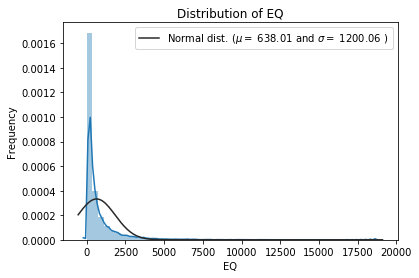

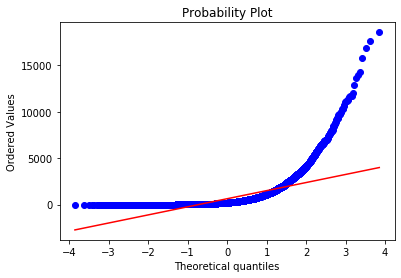

In [173]:
#Distribution of the target variable 'EQ'
sns.distplot(data['EQ'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['EQ'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Distribution of EQ')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['EQ'], plot=plt)
plt.show()


 mu = 5.24 and sigma = 1.74



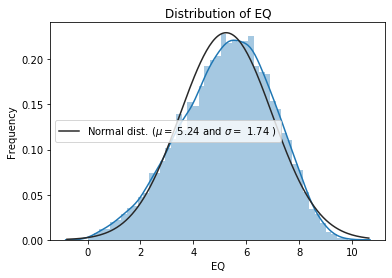

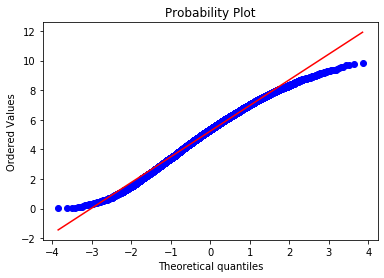

In [174]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data_edited = data.copy()
data_edited['EQ'] = np.log1p(data_edited['EQ'])

#Check the new distribution 
sns.distplot(data_edited['EQ'], fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_edited['EQ'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Distribution of EQ')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data_edited['EQ'], plot=plt)
plt.show()

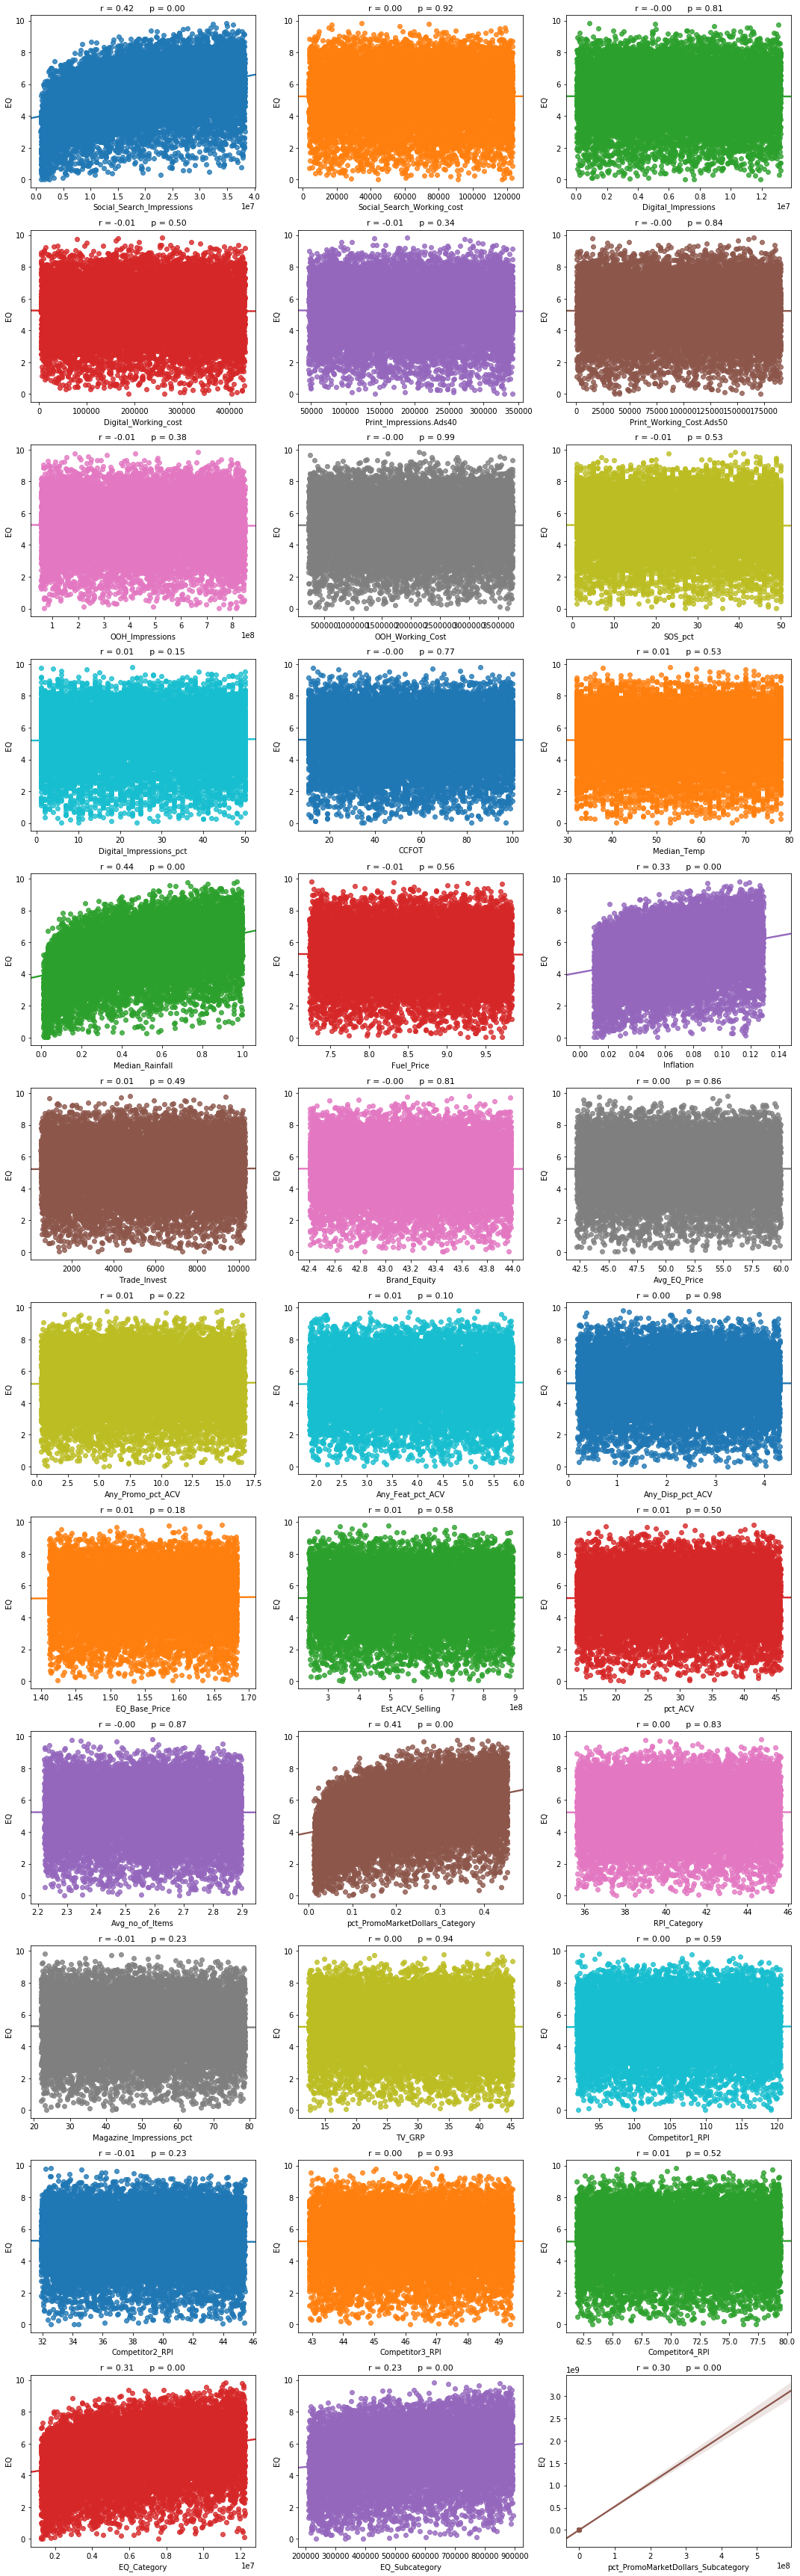

In [175]:
#Let's have a look at the pairplots
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*5,nr_rows*4))

lst_cols = list(data_edited)
lst_cols.remove('EQ')


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(lst_cols):
            sns.regplot(data_edited[lst_cols[i]], data_edited['EQ'], ax = axs[r][c])
            stp = stats.pearsonr(data_edited[lst_cols[i]], data_edited['EQ'])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
           
plt.tight_layout()
plt.show()

In [176]:
#train-test split
train, test = train_test_split(data_edited, train_size = 0.7, test_size = 0.3, random_state = 50)

In [177]:
#Scaling the train and test data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [178]:
#Creating dataframes from the scaled data
train_scaled = pd.DataFrame(train_scaled)
train_scaled.columns = list(train)

test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = list(test)

In [179]:
#Getting the Xs nd ys
y_train = train_scaled.pop('EQ')
X_train = train_scaled
y_test = test_scaled.pop('EQ')
X_test = test_scaled

### RFE

Text(0, 0.5, 'r2_score')

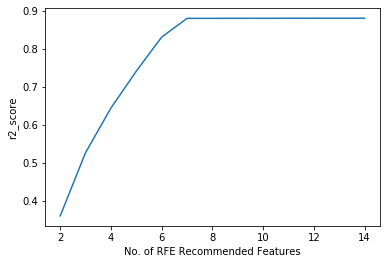

In [180]:
lst_r2 = []
lst_feats = []
for i in range(2,15):
    lr = LinearRegression()
    lr_model = lr.fit(X_train,y_train)
    rfe = RFE(lr_model, i)
    rfe = rfe.fit(X_train, y_train)
    df_rfe = X_train[X_train.columns[rfe.support_]]
    X = sm.add_constant(df_rfe) #addition of constant
    lm = sm.OLS(y_train,X).fit()
    pred = lm.predict(X)
    r2 = r2_score(y_train, pred)
    lst_r2.append(r2)
    lst_feats.append(i)
    
plt.figure(figsize = (6,4))
plt.plot(lst_feats, lst_r2)
plt.xlabel('No. of RFE Recommended Features')
plt.ylabel('r2_score')

So, we have reached the plateau with 7 features. Let's follow the recommendation and check whether we are getting satisfactory result or not.

In [181]:
#Let's move ahead and select top 7 features
rfe = RFE(lr_model, 7)
rfe = rfe.fit(X_train, y_train)

In [182]:
#List of the RFE recommended columns
X_train.columns[rfe.support_]

Index(['Social_Search_Impressions', 'Median_Rainfall', 'Inflation',
       'pct_PromoMarketDollars_Category', 'EQ_Category', 'EQ_Subcategory',
       'pct_PromoMarketDollars_Subcategory'],
      dtype='object')

In [183]:
X_train_rfe = X_train[X_train.columns[rfe.support_]] #df with RFE recommended columns
X_train_rfe.head()

,Social_Search_Impressions,Median_Rainfall,Inflation,pct_PromoMarketDollars_Category,EQ_Category,EQ_Subcategory,pct_PromoMarketDollars_Subcategory
0,0.778353,0.167283,0.462130,0.453351,0.585552,0.567483,0.637825
1,0.809381,0.614007,0.039036,0.053301,0.780339,0.516744,0.714996
2,0.136159,0.131988,0.806037,0.524509,0.493409,0.798474,0.645718
3,0.479214,0.575237,0.689735,0.746187,0.768403,0.175006,0.876060
4,0.634401,0.117250,0.320892,0.941600,0.056452,0.413808,0.645133


### Model Building
#### Application of Linear Regression, ElasticNet and XGBoost

#### Linear Regression

In [184]:
def model(X,y):
    X = sm.add_constant(X) #addition of constant
    lm = sm.OLS(y,X).fit() #fit the model
    print(lm.summary()) #model summary
    
def VIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [185]:
model(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                     EQ   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     8753.
Date:                Tue, 31 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:10:53   Log-Likelihood:                 11497.
No. Observations:                8400   AIC:                        -2.298e+04
Df Residuals:                    8392   BIC:                        -2.292e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

The model looks satisfactory and all the p-values are less than 0.05. Let's check VIFs next.

In [186]:
VIF(X_train_rfe)

,Features,VIF
6,pct_PromoMarketDollars_Subcategory,3.51
3,pct_PromoMarketDollars_Category,3.50
1,Median_Rainfall,3.49
0,Social_Search_Impressions,3.48
4,EQ_Category,3.41
5,EQ_Subcategory,3.41
2,Inflation,3.38


All the VIFs are less than 5!

So, the obtained model is good enough to draw conclusion about the driver features of sales (EQ)

#### Residual Analysis on train dataset

Text(0.5, 1.0, 'Error disribution')

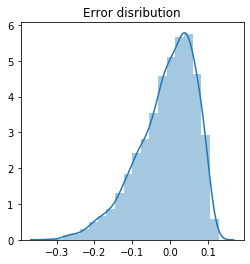

In [187]:
X = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit()
y_train_pred = lm.predict(X_train_rfe)

plt.figure(figsize=(4,4))
sns.distplot((y_train - y_train_pred), bins = 20)
plt.title('Error disribution')

The mean is centered around 0 and the error term looks like near-normal distribution

#### Checking performance in the test dataset

In [188]:
X_test_rfe = X_test[X_test.columns[rfe.support_]]

In [189]:
y_test_pred = lm.predict(X_test_rfe)
print('r2_score in test dataset:', r2_score(y_test, y_test_pred))

r2_score in test dataset: 0.8106776644069833


#### Description of the final model (Linear Regression)

log1p(EQ) = -0.2196 + (0.2550 X Social_Search_Impressions) + (0.2732 X Median_Rainfall) + (0.2127 X Inflation) + (0.2477 X pct_PromoMarketDollars_Category) + (0.1949 X EQ_Category) + (0.1364 X EQ_Subcategory) + (0.1837 X pct_PromoMarketDollars_Subcategory)

#### Conclusion (Linear Regression)

([<matplotlib.axis.XTick at 0x7f71c25a09b0>,
 <a list of 7 Text xticklabel objects>)

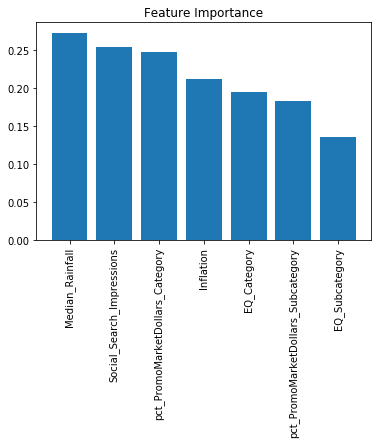

In [190]:
#Feature Importance
feats = ['Median_Rainfall', 'Social_Search_Impressions', 'pct_PromoMarketDollars_Category', 'Inflation', 
         'EQ_Category', 'pct_PromoMarketDollars_Subcategory', 'EQ_Subcategory']
coefs = [0.2732, 0.2550, 0.2477, 0.2127, 0.1949 , 0.1837, 0.1364]

plt.title("Feature Importance")
plt.bar(range(len(feats)), coefs)
plt.xticks(range(len(feats)), feats, rotation=90)

  #### ElasticNet

In [191]:
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=5000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')

In [192]:
cv_model.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1], max_iter=5000,
       n_alphas=100, n_jobs=-1, normalize=True, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [193]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00000844
Optimal l1_ratio: 1.000
Number of iterations 4


In [194]:
# train model with best parameters from CV
model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
model.fit(X_train, y_train)

ElasticNet(alpha=8.435881590125037e-06, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=4, normalize=True, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [195]:
print('r2_score in train dataset', r2_score(y_train, model.predict(X_train)))
print('r2_score in test dataset', r2_score(y_test, model.predict(X_test)))

r2_score in train dataset 0.8796228584962056
r2_score in test dataset 0.8816847288752927


12 features, reduction of 67.57%


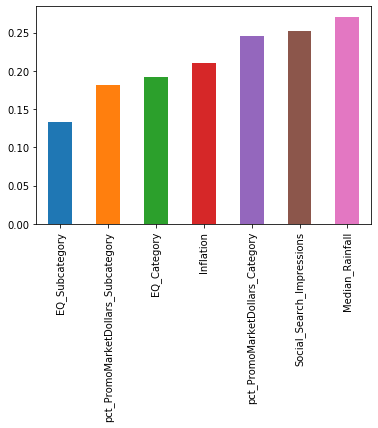

In [196]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(7).plot(kind = 'bar', figsize = (6,4))

#### Conclusion (ElasticNet)
* Accuracy of Linear Regression and ElasticNet are practically same
* Top seven features, along with their relative weights, are same both in Linear Regression and EnasticNet

#### XGBoost

In [197]:
XGB_model = XGBRegressor(n_estimators=3250,learning_rate=0.01, max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.4,
 colsample_bytree=0.25,
 objective = 'reg:squarederror',
 nthread=4,
 seed=27,
 reg_alpha=0.001,
 reg_lambda=10,random_state=42)

XGB_model.fit(X_train, y_train ,early_stopping_rounds=5,
             eval_set=[(X_train, y_train)], verbose=False)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.25, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=3, missing=nan, monotone_constraints=None,
       n_estimators=3250, n_jobs=4, nthread=4, num_parallel_tree=1,
       objective='reg:squarederror', random_state=42, reg_alpha=0.001,
       reg_lambda=10, scale_pos_weight=1, seed=27, subsample=0.4,
       tree_method=None, validate_parameters=False, verbosity=None)

In [198]:
# prediction
y_train_pred = XGB_model.predict(X_train)
y_test_pred = XGB_model.predict(X_test)

print('r2_score in train dataset', r2_score(y_train, y_train_pred))
print('r2_score in test dataset', r2_score(y_test, y_test_pred))

r2_score in train dataset 0.998842824581332
r2_score in test dataset 0.9959174671215563


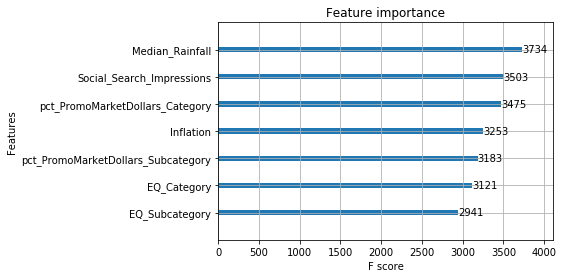

In [199]:
#Top 7 features
xgboost.plot_importance(XGB_model, max_num_features = 7)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

### Saving the Model :

In [200]:
from sklearn.externals import joblib

# Save the model as a pickle in a file 
joblib.dump(XGB_model, 'Feature_Selector_Model.pkl')

['Feature_Selector_Model.pkl']

#### Conclusion (XGBoost)
* Accuracy with XGBoost is the best one
* Top 7 features are same in Linear Regression, EnasticNet and XGBoost.

## Final Conclusion:

* All three models (using Linear Regression, ElasticNet & XGBoost) resulted same top 7 driver features of sale(EQ)
* In terms of accuracy, XGBoost is the winner, r2_score in both train & test dataset is 0.99!